# Generalisation Ability
How well do our models generalise to never before seen data. We evaluate this now by performing Kolmogorov-Smirnov (KS) tests between predicted training and testing data probability distributions.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd
from joblib import load
plt.style.use([hep.style.ROOT, hep.style.firamath])
# We love a nice consistent plotting style

In [25]:
version = '7.0.2'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [71]:
train.category.value_counts()

1    10927
0    10905
Name: category, dtype: int64

In [72]:
test.category.value_counts()

0    3663
1    3615
Name: category, dtype: int64

## Load Models

In [26]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}_tune')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn}

2022-03-24 10:38:44.891551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 10:38:45.016882: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Generate Predictions

In [28]:
predictions = {}

for name, model in models.items():
    if name in ['NN', 'OLDNN']:
        predictions[name] = [model.predict(X_train).flatten(), model.predict(X_test).flatten()]
    else:
        predictions[name] = [model.predict_proba(X_train)[:,1].flatten(), model.predict_proba(X_test)[:,1].flatten()]

2022-03-24 10:43:07.919452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-24 10:43:07.947758: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


## Plot Predictions

In [67]:
# Generate the binned data to plot
bins = np.linspace(0, 1, 51)
norm_frequencies = {}
frequencies = {}

for name, pred in predictions.items():
    norm_frequencies[name] = [np.histogram(pred[0], bins=bins, density=True)[0], np.histogram(pred[1], bins=bins, density=True)[0]]
    frequencies[name] = [np.histogram(pred[0], bins=bins)[0], np.histogram(pred[1], bins=bins)[0]]
    
# Find the error scaling factor as distributions were normalised
scaling_factors = {}
for name, nfreqs in norm_frequencies.items():
    scaling_factors[name] = [np.nanmean(np.divide(nfreqs[0],frequencies[name][0])), np.nanmean(np.divide(nfreqs[1],frequencies[name][1]))]

/tmp/ipykernel_718397/273267393.py:13: RuntimeWarning: invalid value encountered in true_divide
  scaling_factors[name] = [np.nanmean(np.divide(nfreqs[0],frequencies[name][0])), np.nanmean(np.divide(nfreqs[1],frequencies[name][1]))]


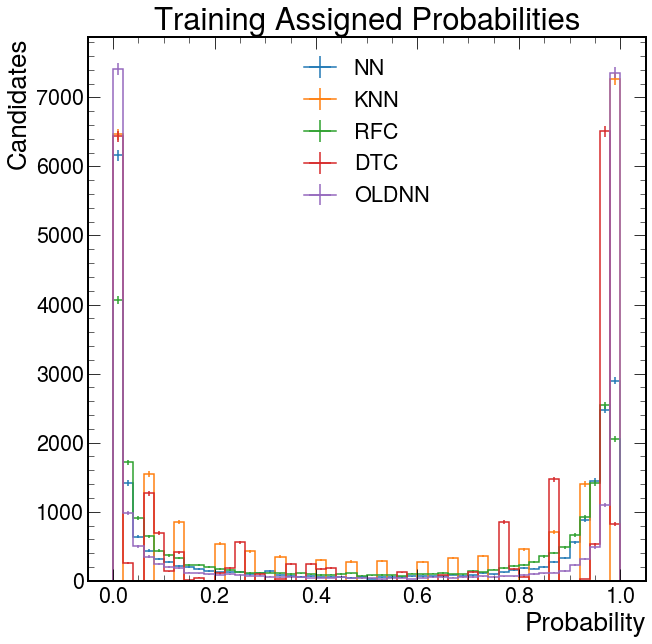

In [68]:
# Plot all of the models train distributions
fig, ax = plt.subplots(1, 1)
hep.histplot([frequencies[key][0] for key in models.keys()], yerr=[np.sqrt(frequencies[key][0]) for key in models.keys()], bins=bins, ax=ax, label=[key for key in models.keys()])
plt.xlabel('Probability')
plt.ylabel('Candidates')
plt.title('Training Assigned Probabilities')
plt.legend(loc='upper center')
plt.savefig('../images/ModelEval/AllModels_Train_Probdist.png', dpi=800)
plt.show()

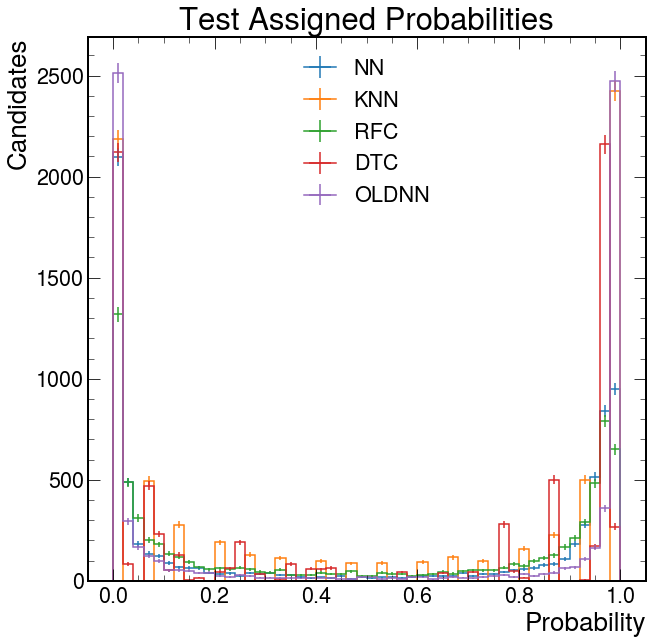

In [69]:
# Plot all of the models test distributions
fig, ax = plt.subplots(1, 1)
hep.histplot([frequencies[key][1] for key in models.keys()], yerr=[np.sqrt(frequencies[key][1]) for key in models.keys()], bins=bins, ax=ax, label=[key for key in models.keys()])
plt.xlabel('Probability')
plt.ylabel('Candidates')
plt.title('Test Assigned Probabilities')
plt.legend(loc='upper center')
plt.savefig('../images/ModelEval/AllModels_Test_Probdist.png', dpi=800)
plt.show()

## KS Testing
Perform the test between the normalised test and train predicted probability distributions (PPDs).

In [70]:
for model_name in models.keys():
    statistic, pvalue = ks_2samp(norm_frequencies[model_name][0], norm_frequencies[model_name][1])
    # The null hypothess is that F(x) = G(x). So a p-value close to 1 and a small statistic mean we cannot reject the null
    # that is that the distributions are the same 

    print(f"Model: {model_name}\nKS Statistic: {statistic:.3f}\nTest P-Value: {pvalue:.3f}\n")

Model: NN
KS Statistic: 0.120
Test P-Value: 0.869

Model: KNN
KS Statistic: 0.040
Test P-Value: 1.000

Model: RFC
KS Statistic: 0.180
Test P-Value: 0.396

Model: DTC
KS Statistic: 0.060
Test P-Value: 1.000

Model: OLDNN
KS Statistic: 0.120
Test P-Value: 0.869



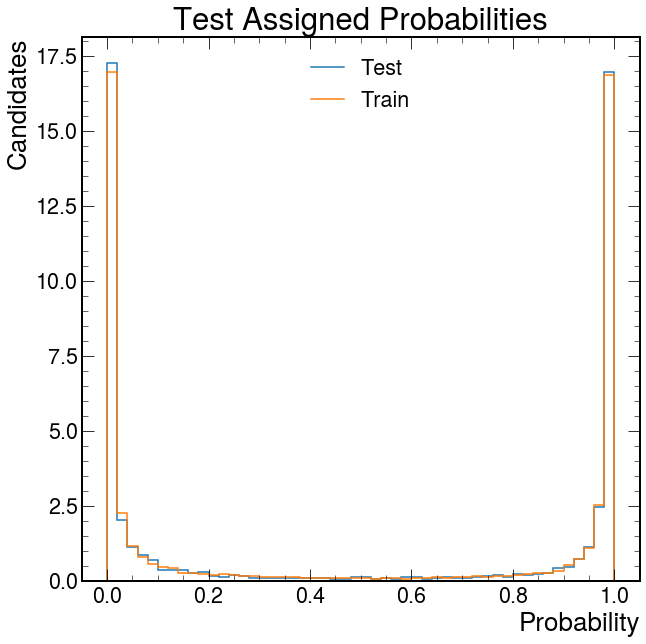

In [78]:
# Plot all of the models test distributions
fig, ax = plt.subplots(1, 1)
hep.histplot([norm_frequencies['OLDNN'][1], norm_frequencies['OLDNN'][0]], yerr=False, bins=bins, ax=ax, label=['Test', 'Train'])
plt.xlabel('Probability')
plt.ylabel('Candidates')
plt.title('Test Assigned Probabilities')
plt.legend(loc='upper center')
plt.savefig('../images/ModelEval/OLDNN_Probdist.png', dpi=800)
plt.show()